# Imports

In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import random

# setting seed
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
(x_train, y_train), (x_val, y_val) = (x_train[:40000], y_train[:40000]), (x_train[40000:], y_train[40000:])
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")

AUTO = tf.data.AUTOTUNE

169017344/169001437 [==============================] - 3s 0us/step
Training samples: 40000
Validation samples: 10000
Testing samples: 10000


# Hyperparameters

In [3]:
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 100
BATCH_SIZE = 512

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

EPOCHS = 50

IMAGE_SIZE = 72  # We'll resize input images to this size
PATCH_SIZE = 6  # Size of the patches to be extract from the input images
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]  # Size of the transformer layers
TRANSFORMER_LAYERS = 8
MLP_HEAD_UNITS = [2048, 1024]  # Size of the dense layers of the final classifier

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train))
train_ds = (
    train_ds
    .shuffle(1024)
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

val_ds = tf.data.Dataset.from_tensor_slices((x_val))
val_ds = (
    val_ds
    .shuffle(1024)
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test))
test_ds = (
    test_ds
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Data Augmentation

In [5]:
def get_augmentation_model():
    model = keras.Sequential([
        layers.Rescaling(1/255.0),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        )],
        name="data_augmentation")
    return model

def get_test_augmentation_model():
    model = keras.Sequential([
        layers.Rescaling(1/255.0),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        ],
        name="test_data_augmentation")
    return model

# Create Patches

In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        # assuming the image has three channels each patch would be
        # of size (patch_size, patch_size, 3)
        self.resize = layers.Reshape((-1, patch_size*patch_size*3))

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = self.resize(patches)
        return patches

# Models

In [7]:
class PatchEncoder(layers.Layer):
    def __init__(self, patch_size, projection_dim, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.batch_size = batch_size

        # this is a trainable mask token as suggested in the paper.
        self.mask_token = tf.Variable(
            tf.random.normal(
                [1, patch_size*patch_size*3]
            ))

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape

        # create the projection layer
        self.projection = layers.Dense(units=self.projection_dim)
        
        # create the positional embedding layer
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim)
        
        # 75% of number of patches should be masked
        self.num_mask = int(0.75 * self.num_patches)

        # create random indices from a uniform distribution and then split
        # it into mask and unmask indices
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(self.batch_size, self.num_patches)),
            axis=-1)
        self.mask_indices = rand_indices[:, :self.num_mask]
        self.unmask_indices = rand_indices[:, self.num_mask:]

    def call(self, patch):
        # patch shape = (B, num_patches, p*p*3)
        # get the positional embeddings
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(pos_embeddings, [self.batch_size, 1, 1]) # (B, num_patches, projection_dim)

        # embedd the patches
        patch_embeddings = self.projection(patch) + pos_embeddings # (B, num_patches, projection_dim)

        # the encoder input is the unmasked patch embeddings
        unmasked_embeddings = tf.gather(
            patch_embeddings,
            self.unmask_indices,
            axis=1,
            batch_dims=1) # (B, unmask_numbers, projection_dim)

        # get the unmasked and masked positions
        unmasked_positions = tf.gather(
            pos_embeddings,
            self.unmask_indices,
            axis=1,
            batch_dims=1) # (B, unmask_numbers, projection_dim)
        masked_positions = tf.gather(
            pos_embeddings,
            self.mask_indices,
            axis=1,
            batch_dims=1) # (B, mask_numbers, projection_dim)

        # repeat the mask token number of mask times
        # mask tokens replace the masks of the image
        mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
        mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...],
                repeats=self.batch_size,
                axis=0)

        # get the masked embeddings
        masked_embeddings = self.projection(mask_tokens) + masked_positions

        return unmasked_embeddings, masked_embeddings, unmasked_positions

In [8]:
def get_mlp(hidden_units, dropout_rate):
    layers_list = []
    for units in hidden_units:
        layers_list.append(layers.Dense(units, activation=tf.nn.gelu))
        layers_list.append(layers.Dropout(dropout_rate))
    
    model = keras.Sequential(layers_list)
    return model

In [9]:
class Encoder(layers.Layer):
    def __init__(self, num_layers, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.num_layers = num_layers
        self.num_heads = num_heads
        
    def build(self, input_shape):
        (_, self.num_unmask, self.projection_dim) = input_shape
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm3 = layers.LayerNormalization(epsilon=1e-6)
        
        self.add1 = layers.Add()
        self.add2 = layers.Add()

        self.mlp = get_mlp(hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)

        self.mha1 = layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.projection_dim//self.num_heads,
            dropout=0.1
        )
    
    def call(self, inputs):
        for _ in range(self.num_layers):
            # Layer normalization 1.
            x1 = self.layer_norm1(inputs)
            # Create a multi-head attention layer.
            attention_output = self.mha1(query=x1, value=x1)
            # Skip connection 1.
            x2 = self.add1([attention_output, inputs])
            # Layer normalization 2.
            x3 = self.layer_norm2(x2)
            # MLP.
            x3 = self.mlp(x3)
            # Skip connection 2.
            inputs = self.add2([x3, x2])

        # Create the encoder ouputs
        encoder_outputs = self.layer_norm3(inputs)
        
        return encoder_outputs

In [10]:
class Decoder(layers.Layer):
    def __init__(self, num_layers, num_heads, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.patch_size = patch_size

    def build(self, input_shape):
        (_, self.num_patches, self.projection_dim) = input_shape
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm3 = layers.LayerNormalization(epsilon=1e-6)

        self.add1 = layers.Add()
        self.add2 = layers.Add()
        
        self.mlp = get_mlp(hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)

        self.mha1 = layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.projection_dim//self.num_heads,
            dropout=0.1)
        
        self.dense = layers.Dense(
            units=self.patch_size*self.patch_size*3,
            activation="sigmoid")
    
    def call(self, inputs):
        for _ in range(self.num_layers):
            # Layer normalization 1.
            x1 = self.layer_norm1(inputs)
            # Create a multi-head attention layer.
            attention_output = self.mha1(query=x1, value=x1)
            # Skip connection 1.
            x2 = self.add1([attention_output, inputs])
            # Layer normalization 2.
            x3 = self.layer_norm2(x2)
            # MLP.
            x3 = self.mlp(x3)
            # Skip connection 2.
            inputs = self.add1([x3, x2])

        # Create the encoder ouputs
        decoder_outputs = self.layer_norm3(inputs)
        decoder_outputs = self.dense(decoder_outputs)
        return decoder_outputs

In [23]:
class MaskedAutoencoder(keras.Model):
    def __init__(self, augmentation_model, patch_layer, patch_encoder, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.augmentation_model = augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder
    
    def compile(self, optimizer, loss):
        super().compile()
        self.optimizer = optimizer
        self.loss = loss
        self.loss_tracker = keras.metrics.Mean(name="loss")
    
    def train_step(self, images):
        with tf.GradientTape() as tape:
            # Augment the input images
            augmeneted_images = self.augmentation_model(images)

            # Patch the augmented images
            patches = self.patch_layer(augmeneted_images)

            # Encode the patches
            (unmasked_embeddings, masked_embeddings, unmasked_positions) = self.patch_encoder(patches)
            encoder_outputs = self.encoder(unmasked_embeddings)
            
            # Create the decoder inputs
            encoder_outputs = encoder_outputs + unmasked_positions
            decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)
            
            # Decode the inputs
            decoder_outputs = self.decoder(decoder_inputs)

            loss_patch = tf.gather(
                patches,
                self.patch_encoder.mask_indices,
                axis=1,
                batch_dims=1)
            loss_output = tf.gather(
                decoder_outputs,
                self.patch_encoder.mask_indices,
                axis=1,
                batch_dims=1)             

            # Compute the total loss
            total_loss = self.loss(loss_patch, loss_output)
        
        # Apply gradients
        train_vars = [
            self.augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g,v))
        self.optimizer.apply_gradients(tv_list)

        # Update the trackers.
        self.loss_tracker.update_state(total_loss)

        return {"loss": self.loss_tracker.result()}
    
    def test_step(self, images):
        # Augment the input images
        augmeneted_images = self.augmentation_model(images)

        # Patch the augmented images
        patches = self.patch_layer(augmeneted_images)

        # Encode the patches
        (unmasked_embeddings, masked_embeddings, unmasked_positions) = self.patch_encoder(patches)
        encoder_outputs = self.encoder(unmasked_embeddings)
        
        # Create the decoder inputs
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)
        
        # Decode the inputs
        decoder_outputs = self.decoder(decoder_inputs)
        
        loss_patch = tf.gather(
            patches,
            self.patch_encoder.mask_indices,
            axis=1,
            batch_dims=1)
        loss_output = tf.gather(
            decoder_outputs,
            self.patch_encoder.mask_indices,
            axis=1,
            batch_dims=1)             

        # Compute the total loss
        total_loss = self.loss(loss_patch, loss_output)
        
        # Update the trackers.
        self.loss_tracker.update_state(total_loss)

        return {"loss": self.loss_tracker.result()}
    
    @property
    def metrics(self):
        return [self.loss_tracker]

In [24]:
keras.backend.clear_session()

augmentation_model = get_augmentation_model()
patch_layer = Patches(patch_size=PATCH_SIZE)
patch_encoder = PatchEncoder(patch_size=PATCH_SIZE, projection_dim=PROJECTION_DIM, batch_size=BATCH_SIZE)
encoder = Encoder(num_layers=TRANSFORMER_LAYERS, num_heads=NUM_HEADS)
decoder = Decoder(num_layers=2, num_heads=2, patch_size=PATCH_SIZE)

mae = MaskedAutoencoder(
    augmentation_model=augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder)

mae.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanSquaredError(),
)

In [25]:
# taken from https://stackoverflow.com/a/58082878/10319735
def reconstruct_from_patch(patches):
    patches_tmp = tf.reshape(patches, (144, 6, 6 ,3))
    rows = tf.split(patches_tmp, 12, axis=0)
    rows = [tf.concat(tf.unstack(x),axis=1) for x in rows]
    reconstructed = tf.concat(rows,axis=0)
    return reconstructed

In [26]:
test_images = next(iter(test_ds))
aug_model = get_test_augmentation_model()
class TrainMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_augmeneted_images = aug_model(test_images)
        test_patches = self.model.patch_layer(test_augmeneted_images)
        (test_unmasked_embeddings, test_masked_embeddings, test_unmasked_positions) = self.model.patch_encoder(test_patches)
        test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
        test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
        test_decoder_inputs = tf.concat([test_encoder_outputs, test_masked_embeddings], axis=1)
        test_decoder_outputs = self.model.decoder(test_decoder_inputs)

        # Plot the images
        original = reconstruct_from_patch(test_patches[0])
        reconstructed = reconstruct_from_patch(test_decoder_outputs[0])
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        ax[0].imshow(tf.keras.preprocessing.image.array_to_img(original))
        ax[0].set_title(f"Original: {epoch:03d}")

        ax[1].imshow(tf.keras.preprocessing.image.array_to_img(reconstructed))
        ax[1].set_title(f"Resonstructed: {epoch:03d}")
        
        plt.show()
        plt.close()

In [27]:
train_callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, verbose=1
    ),
    TrainMonitor()
]

Epoch 1/50
15/15 [==============================] - ETA: 0s - loss: 0.0769

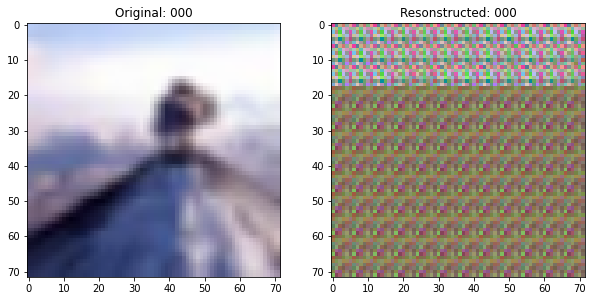

15/15 [==============================] - 11s 250ms/step - loss: 0.0769 - val_loss: 0.0674 - lr: 0.0010
Epoch 2/50
15/15 [==============================] - ETA: 0s - loss: 0.0603

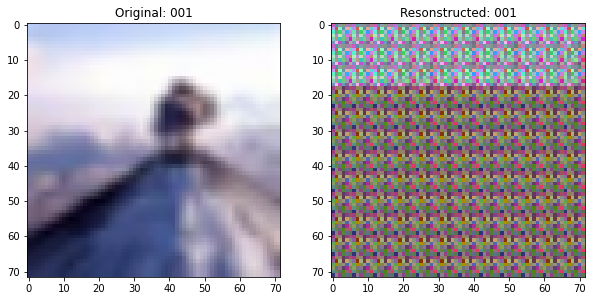

15/15 [==============================] - 3s 174ms/step - loss: 0.0603 - val_loss: 0.0557 - lr: 0.0010
Epoch 3/50
15/15 [==============================] - ETA: 0s - loss: 0.0505

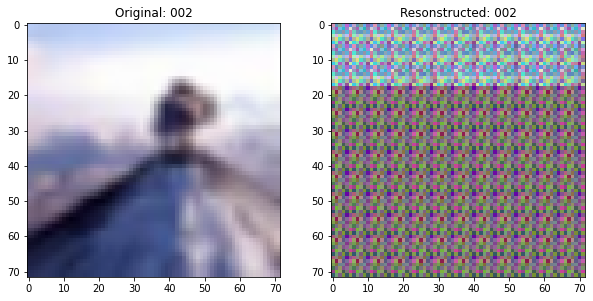

15/15 [==============================] - 2s 162ms/step - loss: 0.0505 - val_loss: 0.0476 - lr: 0.0010
Epoch 4/50
15/15 [==============================] - ETA: 0s - loss: 0.0455

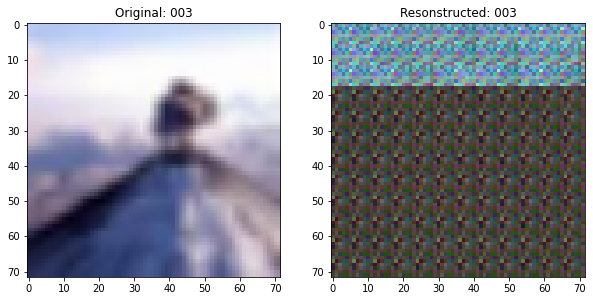

15/15 [==============================] - 2s 163ms/step - loss: 0.0455 - val_loss: 0.0445 - lr: 0.0010
Epoch 5/50
15/15 [==============================] - ETA: 0s - loss: 0.0433

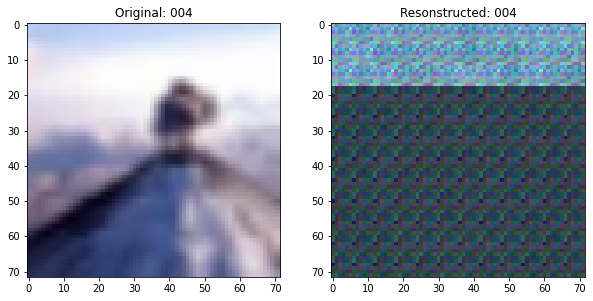

15/15 [==============================] - 2s 162ms/step - loss: 0.0433 - val_loss: 0.0441 - lr: 0.0010
Epoch 6/50
15/15 [==============================] - ETA: 0s - loss: 0.0428

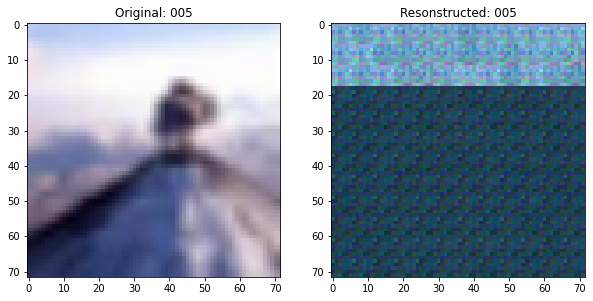

15/15 [==============================] - 2s 163ms/step - loss: 0.0428 - val_loss: 0.0427 - lr: 0.0010
Epoch 7/50
15/15 [==============================] - ETA: 0s - loss: 0.0424

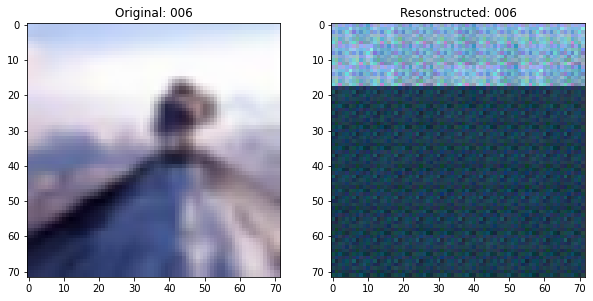

15/15 [==============================] - 2s 163ms/step - loss: 0.0424 - val_loss: 0.0426 - lr: 0.0010
Epoch 8/50
15/15 [==============================] - ETA: 0s - loss: 0.0422

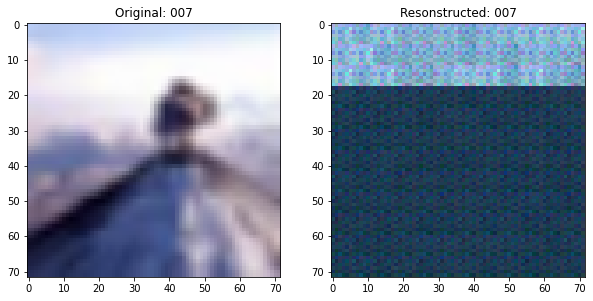

15/15 [==============================] - 2s 162ms/step - loss: 0.0422 - val_loss: 0.0421 - lr: 0.0010
Epoch 9/50
15/15 [==============================] - ETA: 0s - loss: 0.0417

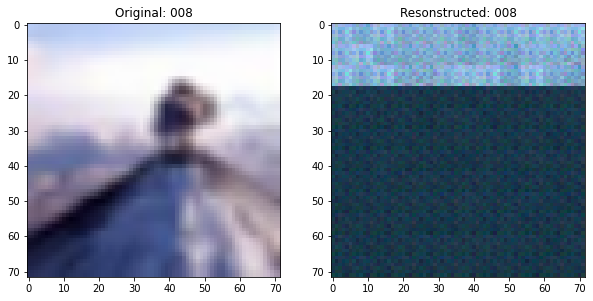

15/15 [==============================] - 2s 163ms/step - loss: 0.0417 - val_loss: 0.0419 - lr: 0.0010
Epoch 10/50
15/15 [==============================] - ETA: 0s - loss: 0.0411

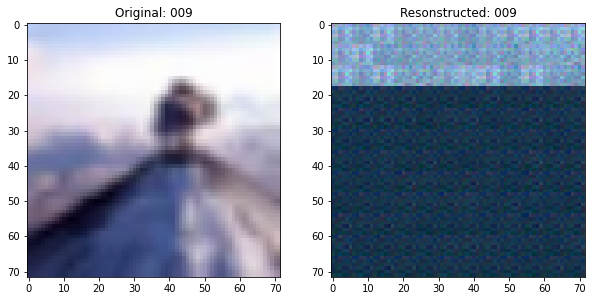

15/15 [==============================] - 2s 162ms/step - loss: 0.0411 - val_loss: 0.0414 - lr: 0.0010
Epoch 11/50
15/15 [==============================] - ETA: 0s - loss: 0.0407

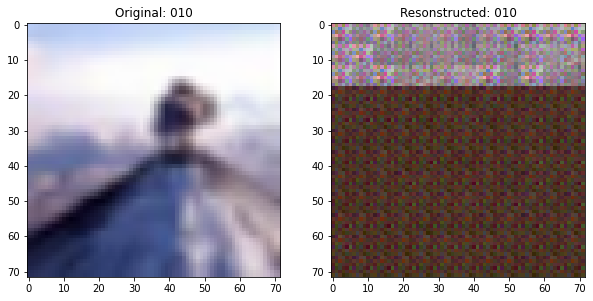

15/15 [==============================] - 2s 162ms/step - loss: 0.0407 - val_loss: 0.0414 - lr: 0.0010
Epoch 12/50
15/15 [==============================] - ETA: 0s - loss: 0.0394

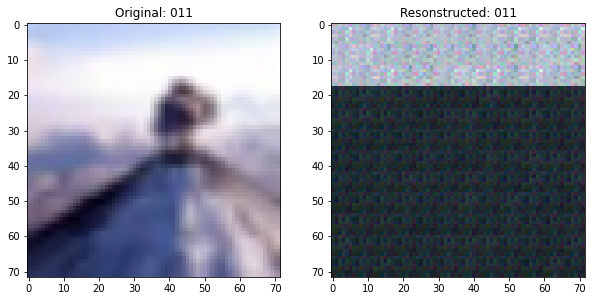

15/15 [==============================] - 2s 162ms/step - loss: 0.0394 - val_loss: 0.0388 - lr: 0.0010
Epoch 13/50
15/15 [==============================] - ETA: 0s - loss: 0.0388

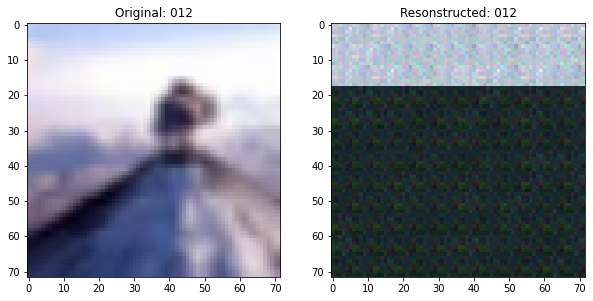

15/15 [==============================] - 2s 163ms/step - loss: 0.0388 - val_loss: 0.0383 - lr: 0.0010
Epoch 14/50
15/15 [==============================] - ETA: 0s - loss: 0.0378

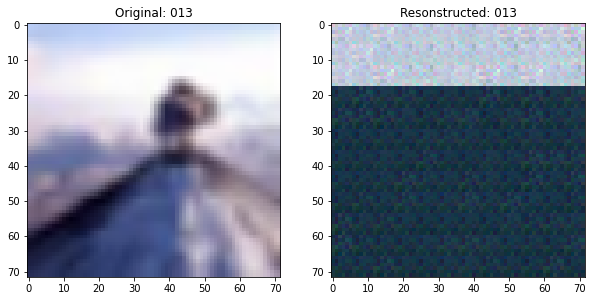

15/15 [==============================] - 2s 162ms/step - loss: 0.0378 - val_loss: 0.0382 - lr: 0.0010
Epoch 15/50
15/15 [==============================] - ETA: 0s - loss: 0.0374

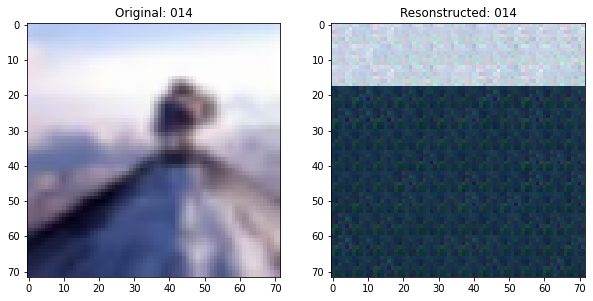

15/15 [==============================] - 2s 163ms/step - loss: 0.0374 - val_loss: 0.0384 - lr: 0.0010
Epoch 16/50
15/15 [==============================] - ETA: 0s - loss: 0.0375
Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


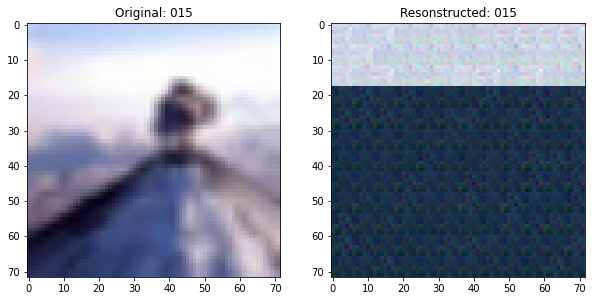

15/15 [==============================] - 2s 164ms/step - loss: 0.0375 - val_loss: 0.0387 - lr: 0.0010
Epoch 17/50
15/15 [==============================] - ETA: 0s - loss: 0.0372

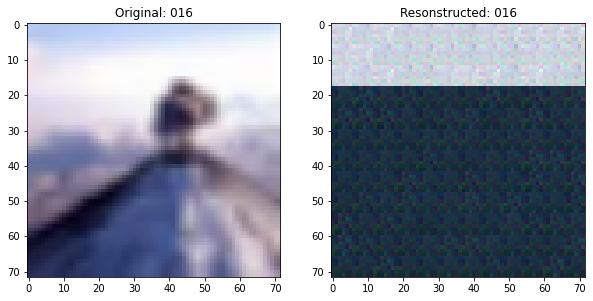

15/15 [==============================] - 2s 162ms/step - loss: 0.0372 - val_loss: 0.0384 - lr: 5.0000e-04
Epoch 18/50
15/15 [==============================] - ETA: 0s - loss: 0.0376

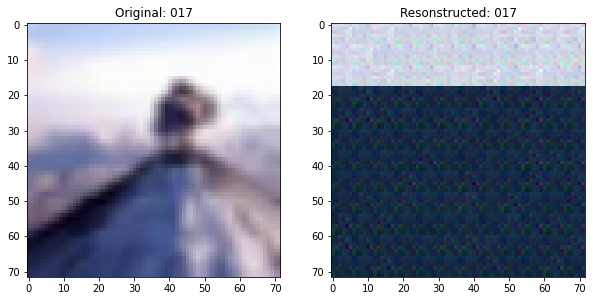

15/15 [==============================] - 2s 163ms/step - loss: 0.0376 - val_loss: 0.0377 - lr: 5.0000e-04
Epoch 19/50
15/15 [==============================] - ETA: 0s - loss: 0.0371

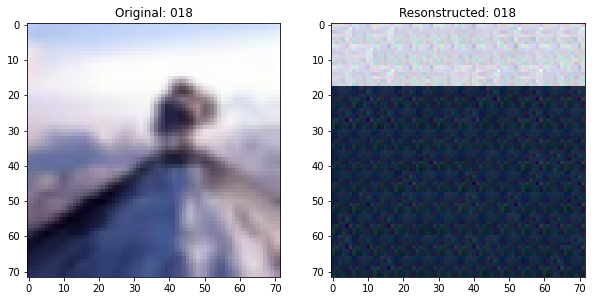

15/15 [==============================] - 2s 163ms/step - loss: 0.0371 - val_loss: 0.0376 - lr: 5.0000e-04
Epoch 20/50
15/15 [==============================] - ETA: 0s - loss: 0.0367

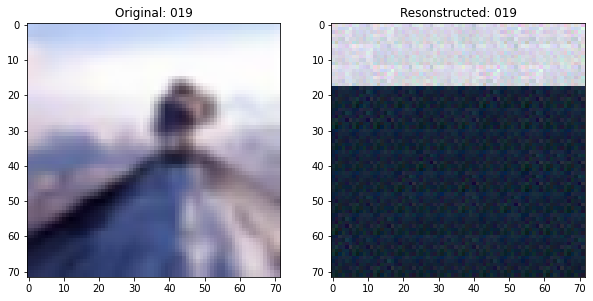

15/15 [==============================] - 2s 163ms/step - loss: 0.0367 - val_loss: 0.0380 - lr: 5.0000e-04
Epoch 21/50
15/15 [==============================] - ETA: 0s - loss: 0.0370
Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


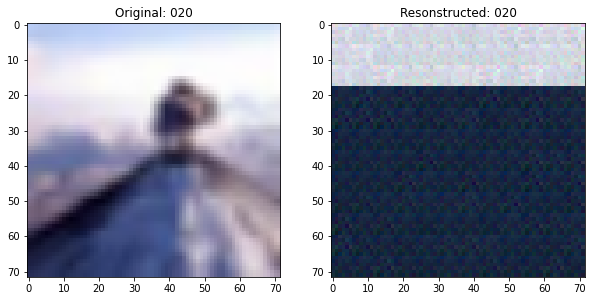

15/15 [==============================] - 2s 162ms/step - loss: 0.0370 - val_loss: 0.0377 - lr: 5.0000e-04
Epoch 22/50
15/15 [==============================] - ETA: 0s - loss: 0.0367

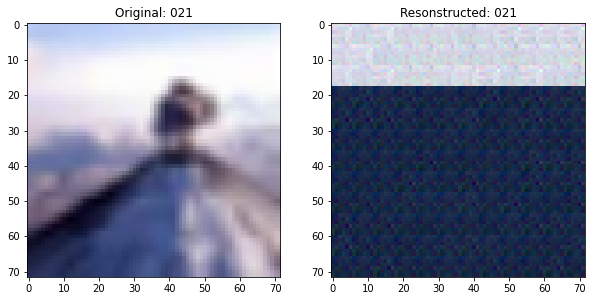

15/15 [==============================] - 2s 163ms/step - loss: 0.0367 - val_loss: 0.0374 - lr: 2.5000e-04
Epoch 23/50
15/15 [==============================] - ETA: 0s - loss: 0.0373

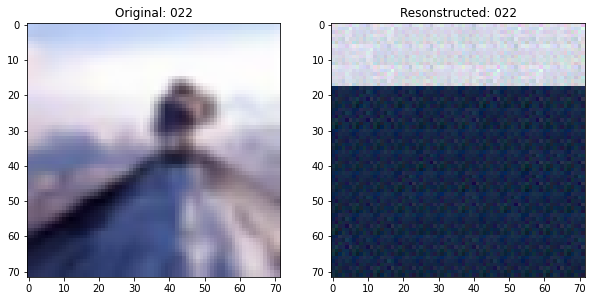

15/15 [==============================] - 2s 162ms/step - loss: 0.0373 - val_loss: 0.0370 - lr: 2.5000e-04
Epoch 24/50
15/15 [==============================] - ETA: 0s - loss: 0.0371

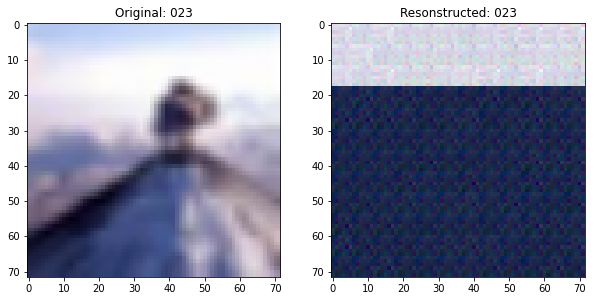

15/15 [==============================] - 3s 178ms/step - loss: 0.0371 - val_loss: 0.0374 - lr: 2.5000e-04
Epoch 25/50
15/15 [==============================] - ETA: 0s - loss: 0.0364

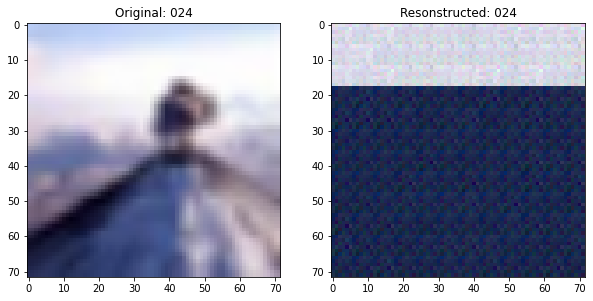

15/15 [==============================] - 2s 162ms/step - loss: 0.0364 - val_loss: 0.0374 - lr: 2.5000e-04
Epoch 26/50
15/15 [==============================] - ETA: 0s - loss: 0.0365
Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


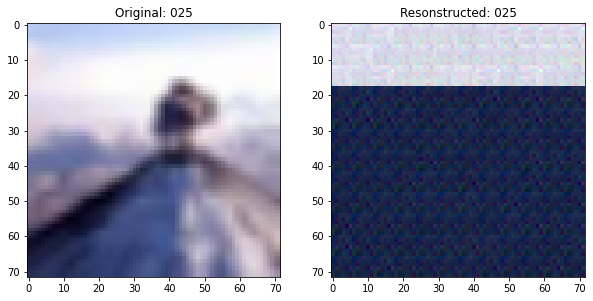

15/15 [==============================] - 2s 162ms/step - loss: 0.0365 - val_loss: 0.0375 - lr: 2.5000e-04
Epoch 27/50
15/15 [==============================] - ETA: 0s - loss: 0.0368

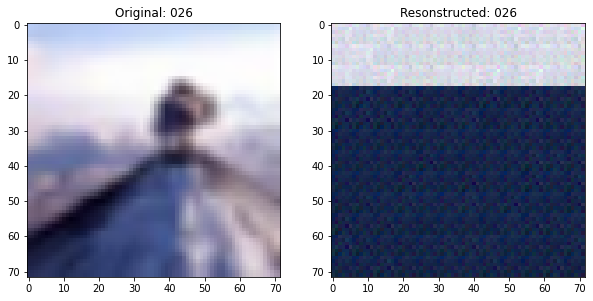

15/15 [==============================] - 2s 163ms/step - loss: 0.0368 - val_loss: 0.0372 - lr: 1.2500e-04
Epoch 28/50
15/15 [==============================] - ETA: 0s - loss: 0.0370

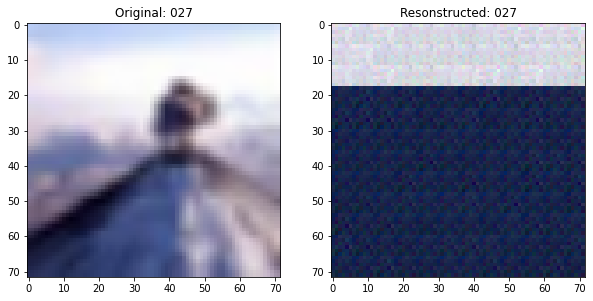

15/15 [==============================] - 2s 162ms/step - loss: 0.0370 - val_loss: 0.0371 - lr: 1.2500e-04
Epoch 29/50
15/15 [==============================] - ETA: 0s - loss: 0.0369
Epoch 00029: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


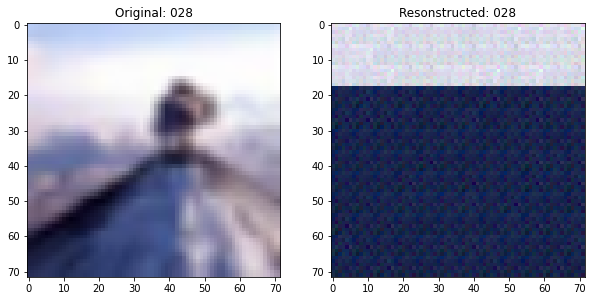

15/15 [==============================] - 2s 162ms/step - loss: 0.0369 - val_loss: 0.0371 - lr: 1.2500e-04
Epoch 30/50
15/15 [==============================] - ETA: 0s - loss: 0.0365

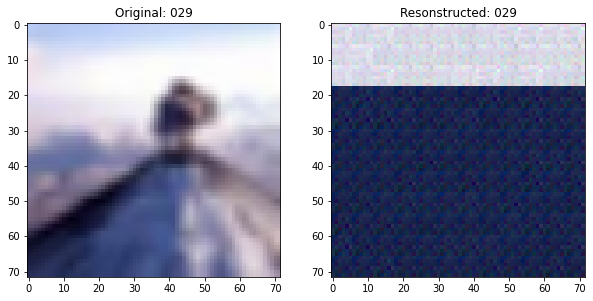

15/15 [==============================] - 2s 164ms/step - loss: 0.0365 - val_loss: 0.0373 - lr: 6.2500e-05
Epoch 31/50
15/15 [==============================] - ETA: 0s - loss: 0.0365

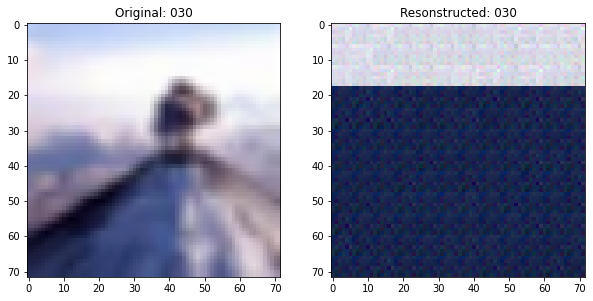

15/15 [==============================] - 2s 163ms/step - loss: 0.0365 - val_loss: 0.0372 - lr: 6.2500e-05
Epoch 32/50
15/15 [==============================] - ETA: 0s - loss: 0.0365
Epoch 00032: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.


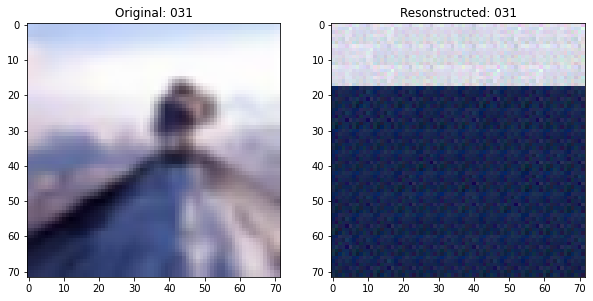

15/15 [==============================] - 2s 163ms/step - loss: 0.0365 - val_loss: 0.0372 - lr: 6.2500e-05
Epoch 33/50
15/15 [==============================] - ETA: 0s - loss: 0.0367

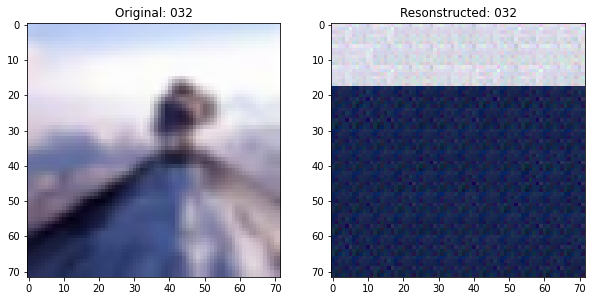

15/15 [==============================] - 2s 164ms/step - loss: 0.0367 - val_loss: 0.0376 - lr: 3.1250e-05
Epoch 34/50
15/15 [==============================] - ETA: 0s - loss: 0.0369

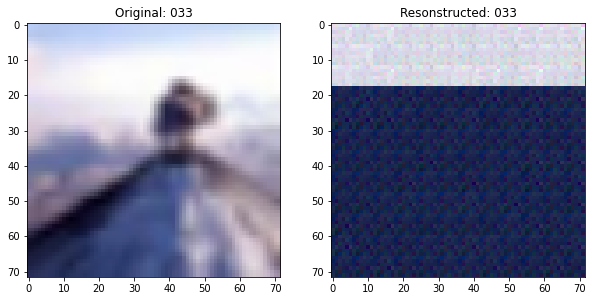

15/15 [==============================] - 2s 162ms/step - loss: 0.0369 - val_loss: 0.0370 - lr: 3.1250e-05
Epoch 35/50
15/15 [==============================] - ETA: 0s - loss: 0.0367
Epoch 00035: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.


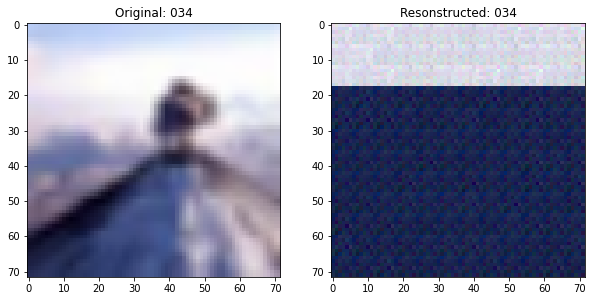

15/15 [==============================] - 2s 163ms/step - loss: 0.0367 - val_loss: 0.0377 - lr: 3.1250e-05
Epoch 36/50
15/15 [==============================] - ETA: 0s - loss: 0.0364

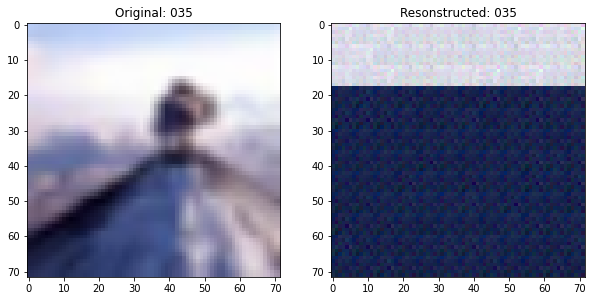

15/15 [==============================] - 2s 163ms/step - loss: 0.0364 - val_loss: 0.0375 - lr: 1.5625e-05
Epoch 37/50
15/15 [==============================] - ETA: 0s - loss: 0.0365

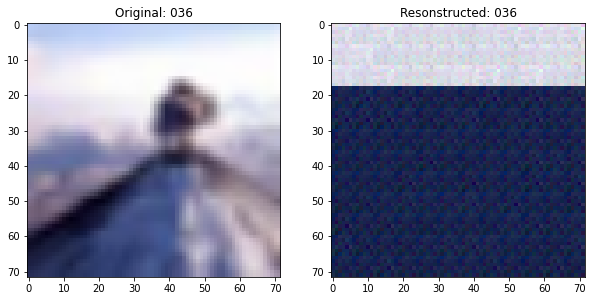

15/15 [==============================] - 2s 162ms/step - loss: 0.0365 - val_loss: 0.0372 - lr: 1.5625e-05
Epoch 38/50
15/15 [==============================] - ETA: 0s - loss: 0.0366
Epoch 00038: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.


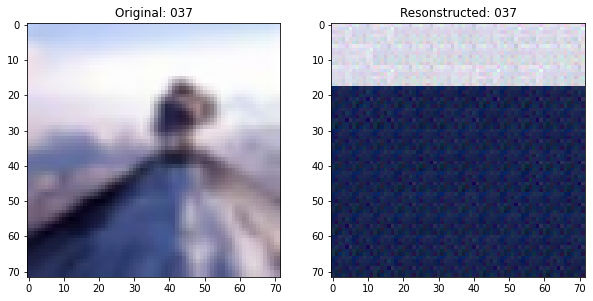

15/15 [==============================] - 2s 163ms/step - loss: 0.0366 - val_loss: 0.0372 - lr: 1.5625e-05
Epoch 39/50
15/15 [==============================] - ETA: 0s - loss: 0.0369

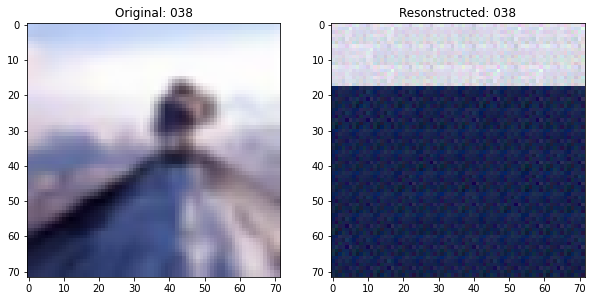

15/15 [==============================] - 2s 162ms/step - loss: 0.0369 - val_loss: 0.0370 - lr: 7.8125e-06
Epoch 40/50
15/15 [==============================] - ETA: 0s - loss: 0.0367

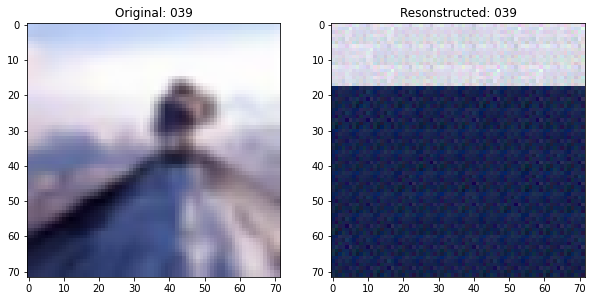

15/15 [==============================] - 2s 162ms/step - loss: 0.0367 - val_loss: 0.0373 - lr: 7.8125e-06
Epoch 41/50
15/15 [==============================] - ETA: 0s - loss: 0.0363
Epoch 00041: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.


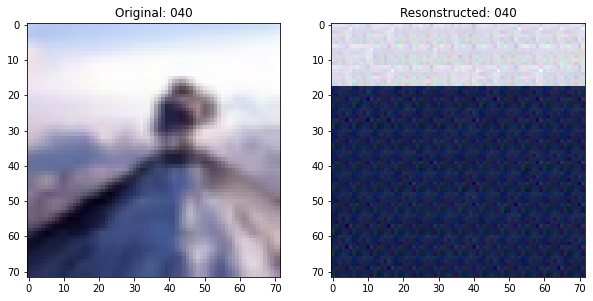

15/15 [==============================] - 2s 164ms/step - loss: 0.0363 - val_loss: 0.0375 - lr: 7.8125e-06
Epoch 42/50
15/15 [==============================] - ETA: 0s - loss: 0.0365

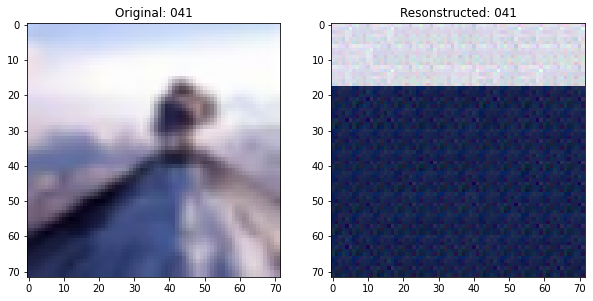

15/15 [==============================] - 2s 162ms/step - loss: 0.0365 - val_loss: 0.0374 - lr: 3.9063e-06
Epoch 43/50
15/15 [==============================] - ETA: 0s - loss: 0.0365

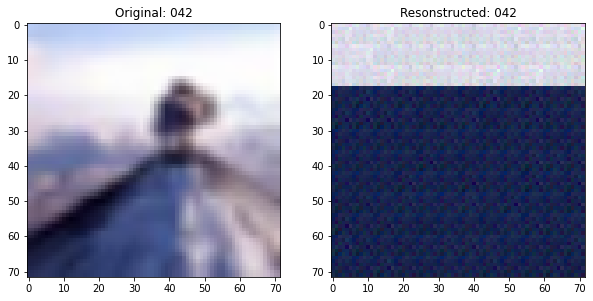

15/15 [==============================] - 2s 162ms/step - loss: 0.0365 - val_loss: 0.0370 - lr: 3.9063e-06
Epoch 44/50
15/15 [==============================] - ETA: 0s - loss: 0.0370
Epoch 00044: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.


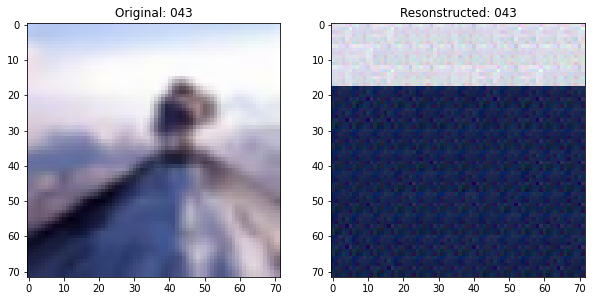

15/15 [==============================] - 2s 162ms/step - loss: 0.0370 - val_loss: 0.0375 - lr: 3.9063e-06
Epoch 45/50
15/15 [==============================] - ETA: 0s - loss: 0.0368

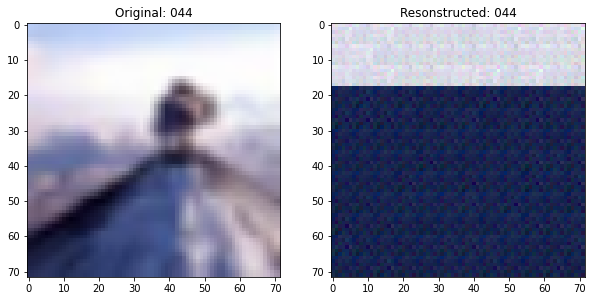

15/15 [==============================] - 2s 162ms/step - loss: 0.0368 - val_loss: 0.0372 - lr: 1.9531e-06
Epoch 46/50
15/15 [==============================] - ETA: 0s - loss: 0.0363

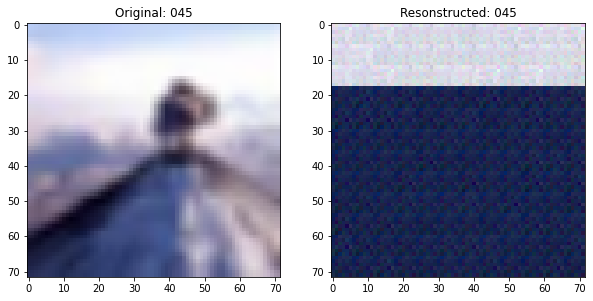

15/15 [==============================] - 3s 178ms/step - loss: 0.0363 - val_loss: 0.0369 - lr: 1.9531e-06
Epoch 47/50
15/15 [==============================] - ETA: 0s - loss: 0.0363
Epoch 00047: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.


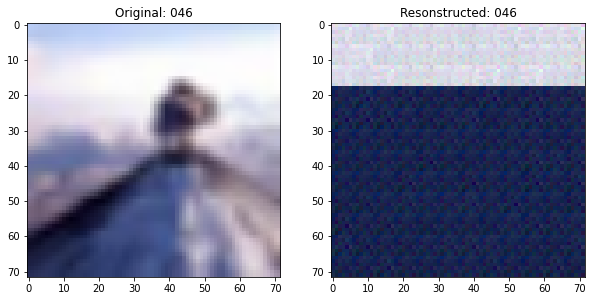

15/15 [==============================] - 2s 162ms/step - loss: 0.0363 - val_loss: 0.0369 - lr: 1.9531e-06
Epoch 48/50
15/15 [==============================] - ETA: 0s - loss: 0.0366

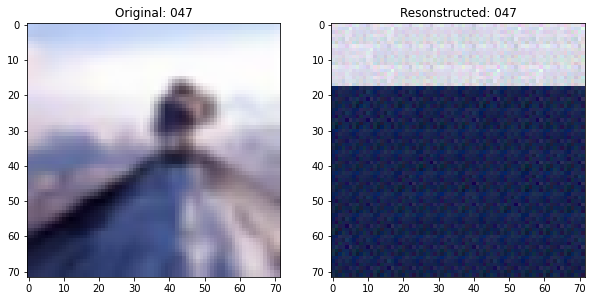

15/15 [==============================] - 2s 163ms/step - loss: 0.0366 - val_loss: 0.0372 - lr: 9.7656e-07
Epoch 49/50
15/15 [==============================] - ETA: 0s - loss: 0.0369

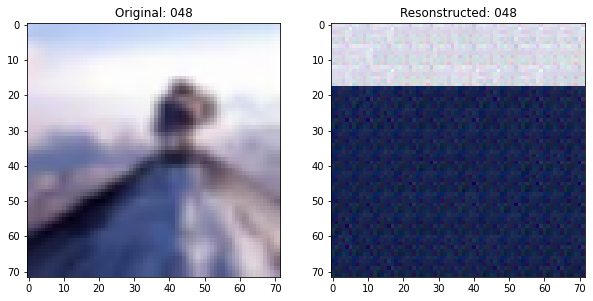

15/15 [==============================] - 2s 161ms/step - loss: 0.0369 - val_loss: 0.0373 - lr: 9.7656e-07
Epoch 50/50
15/15 [==============================] - ETA: 0s - loss: 0.0369
Epoch 00050: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.


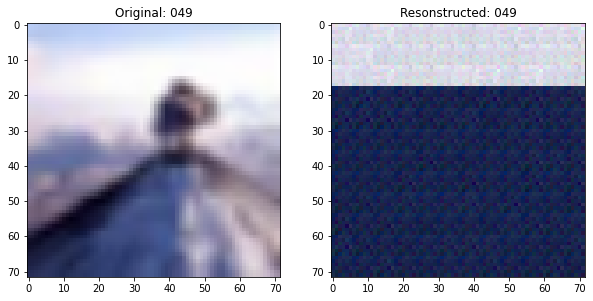

15/15 [==============================] - 2s 163ms/step - loss: 0.0369 - val_loss: 0.0369 - lr: 9.7656e-07


In [28]:
history = mae.fit(
    train_ds,
    steps_per_epoch=15,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=5,
    callbacks=train_callbacks)

In [29]:
loss = mae.evaluate(test_ds, steps=5)
print(f"Loss: {loss:.2f}")

5/5 [==============================] - 0s 49ms/step - loss: 0.0370
Loss: 0.04
